# Predict the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 70/20/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 198.35
- MAE: 157.40
- MAPE: 1.43 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> ITD - 7 2 1
split = 0
stock = 2  # ITD

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1308,2024-05-27,11300,11600,11300,11300,47400,ITD
1309,2024-05-28,11650,12050,11400,12050,322600,ITD
1310,2024-05-29,12850,12850,12450,12600,334600,ITD
1311,2024-05-30,12600,12600,12100,12500,299000,ITD


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [6]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,9972.168317,10160.894897
std,2917.997297,3002.802575
min,5130.000000,5320.000000
25%,7460.000000,7550.000000
50%,9900.000000,10040.000000
75%,11500.000000,11650.000000
max,20700.000000,21430.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

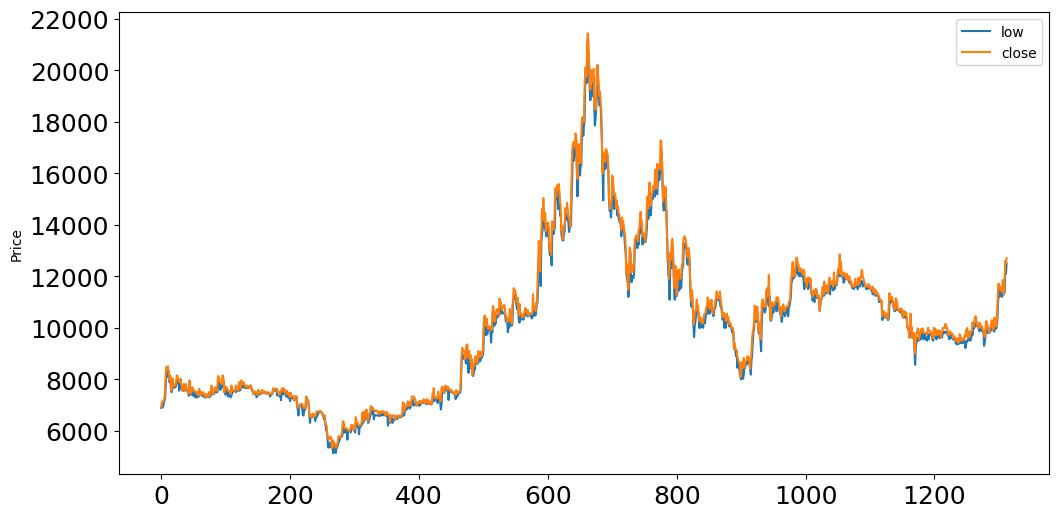

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.58452370712745,
 0.49136294807853553,
 12,
 1300,
 {'1%': -3.435390199468821,
  '5%': -2.8637658312426035,
  '10%': -2.567955046745562},
 18249.614062380075)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.848
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.843
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


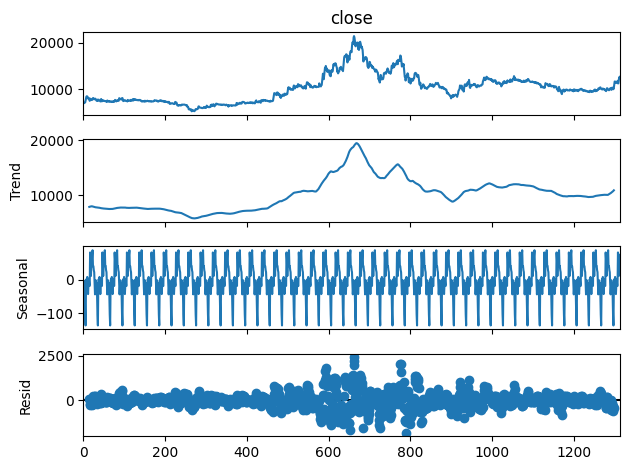

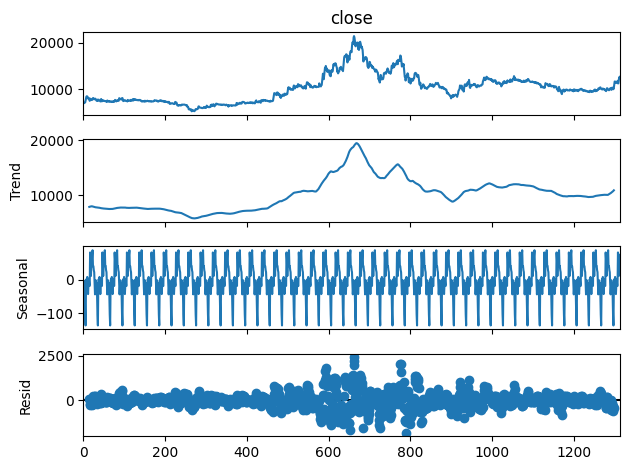

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-9.05389535852299,
 4.7585079585462e-15,
 11,
 906,
 {'1%': -3.4375883271133243,
  '5%': -2.8647353885968214,
  '10%': -2.568471435365895},
 12798.627520578957)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

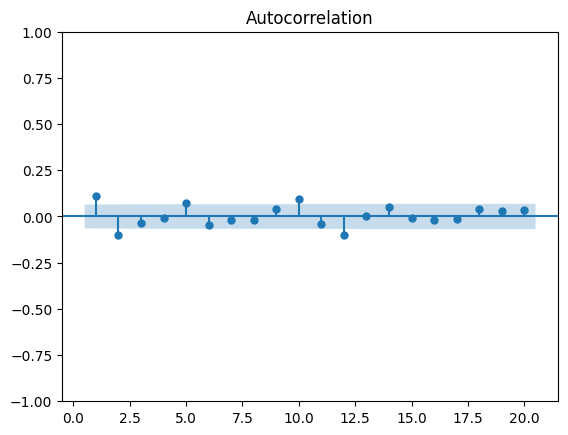

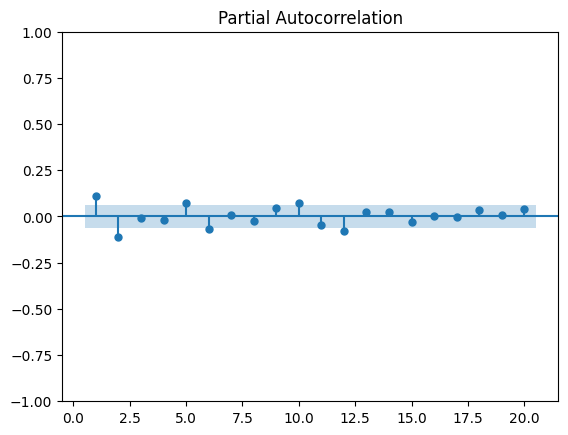

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=13104.732, Time=4.07 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13127.555, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=13113.967, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13111.886, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=13125.653, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=13107.874, Time=2.07 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=13106.736, Time=1.08 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=13100.037, Time=4.25 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=13101.970, Time=2.85 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=13101.251, Time=4.20 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=13101.727, Time=4.12 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=13098.450, Time=2.46 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=13103.904, Time=1.91 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=13101.288, Time=1.94 sec
 ARIMA(1,1,2)(2,0,2

In [23]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 5)   Log Likelihood               -6541.268
Date:                             Thu, 06 Jun 2024   AIC                          13096.536
Time:                                     22:27:15   BIC                          13130.291
Sample:                                          0   HQIC                         13109.419
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6703      0.121      5.555      0.000       0.434       0.907
ma.L1         -0.5379      

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(1, 1, 2),
    seasonal_order=(2, 0, 1, 5),
)

model_fit = model1.fit()

C:\Users\datdao2003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\datdao2003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\datdao2003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([ 9990.82409006, 10234.43201991, 10610.76151107, 10931.38902431,
       10511.81390545, 10449.47526199, 10517.94732414, 10787.97561905,
       10055.06890985,  9975.36793181,  9925.49399475,  9725.9599656 ,
        9267.45269603, 10331.77498511, 10864.41379786, 11052.93634999,
       11020.76626225, 10971.60638019, 10831.4215384 , 10947.80970795,
       11124.26976939, 11390.09174554, 11388.67012959, 11478.40584578,
       11088.22252901, 11469.77104485, 10646.20862305, 10505.69844363,
       10558.09924194, 10765.80524295, 11074.13473085, 10832.64815509,
       11023.98279741, 11113.66903799, 11230.61332916, 11145.50277991,
       10839.29242607, 11246.4675766 , 10974.23284604, 11131.23183388,
       10942.49625914, 10883.53498913, 10699.58523466, 10647.24223667,
       10449.67397167, 10638.42740611, 11022.03725601, 11013.24127398,
       10883.00907006, 10664.70932748, 10760.00400744, 10974.87586773,
       11024.28834627, 10840.07023526, 10672.89214009, 11054.36638333,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 9970.53623129,  9990.97771462,  9738.38358378,  9795.26893296,
        9974.18564793,  9830.69556938,  9767.29654949,  9722.8630334 ,
        9831.90246334,  9904.3604261 ,  9742.90326579,  9979.55820028,
        9936.95203558,  9986.88138595,  9910.88443547,  9967.53590557,
        9732.48723008,  9723.90306558,  9928.61182295,  9913.12891046,
        9906.99824294,  9929.3659138 ,  9735.20963949,  9794.51356752,
        9911.52672011,  9917.74984862,  9885.41391901,  9826.05517469,
       10030.61491381,  9832.56373934,  9826.43141624,  9858.83093393,
       10050.16557625, 10038.41252295, 10013.3418027 , 10019.52661794,
       10037.92200449, 10079.91569708, 10081.56705998,  9954.53602498,
        9897.67153227,  9940.14955613,  9735.91194289,  9805.29609753,
        9983.05321986, 10009.50378411,  9784.47787078,  9907.55297079,
        9777.32076687,  9751.75568264,  9776.04285689,  9828.61184698,
        9583.8503733 ,  9582.22299126,  9557.05990751,  9593.64055158,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[17176.57128338 17296.89794601 17215.19650016 17270.52773476
 17275.44353557 17262.27042447 17248.03693694 17293.34467075
 17309.53462162 17289.14310532 17288.43470061 17330.80086217
 17296.78451228 17304.58403052 17338.61618871 17353.13782668
 17329.55755374 17380.28285098 17390.70283541 17373.66580835
 17376.12495563 17417.22637068 17383.81885199 17390.84901849
 17425.1566214  17439.96956472 17416.22344992 17466.89381428
 17477.16478046 17460.15022037]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

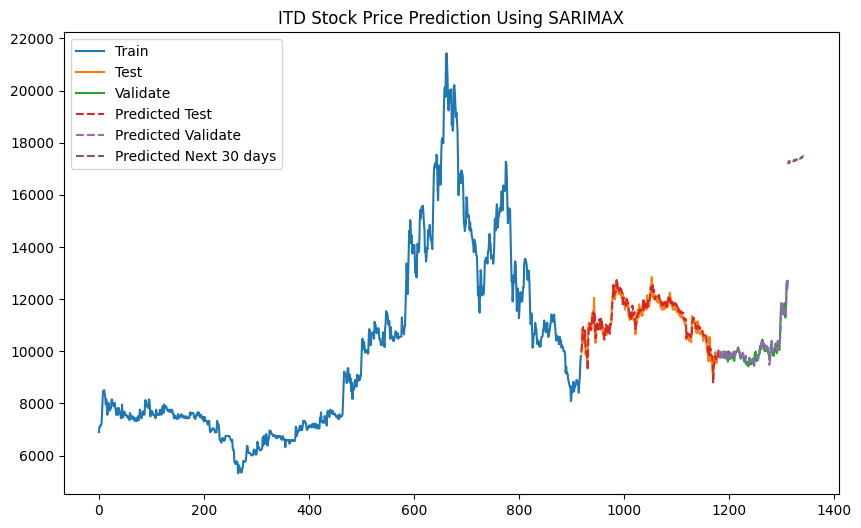

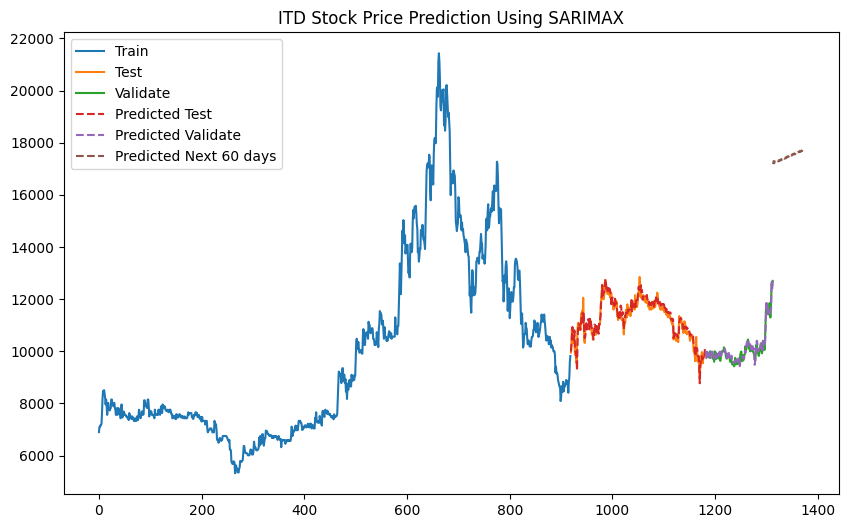

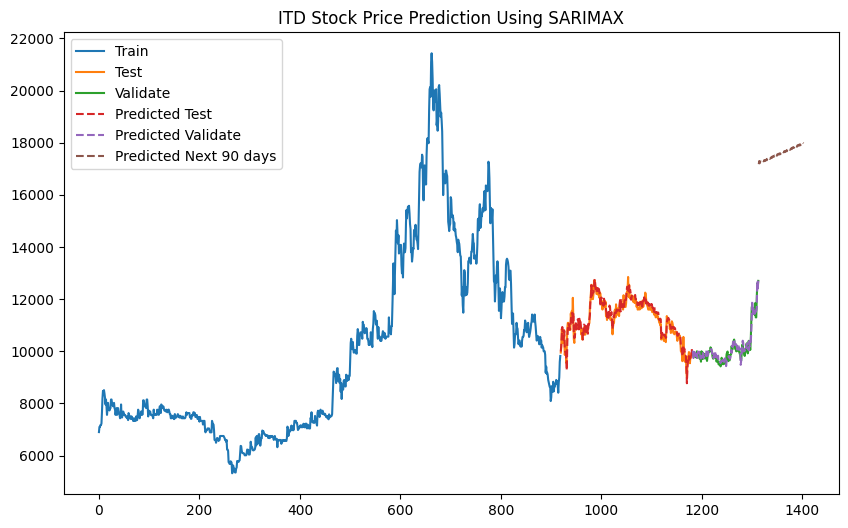

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 197.6654082909399
MAE on test data: 161.55497029989172
MAPE on test data: 1.445614433165069 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 153.8729572780959
MAE on validation data: 127.62133385223828
MAPE on validation data: 1.2603332213228278 %
